In [1]:
import pandas 
import numpy 
import matplotlib.pyplot 
import torch
from src import tokenize
from CustomDatasets.PeptidesWithRetentionTimes import PeptidesWithRetentionTimes
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 64,
                output_size = 1, numberOfHeads = 16) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.ao.nn.quantizable.MultiheadAttention.html#multiheadattention
        self.linear1 = torch.nn.Linear(hidden_size*200, output_size, dtype=torch.float32)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x) -> torch.Tensor:
        # print(x.shape)
        x = x.view(x.size(0), x.size(2)*2)
        # print(x.shape)
        embedded = self.embedding(x)
        # print(embedded.shape)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        lstm_out, _ = self.lstm(embedded)
        # print(lstm_out.shape)
        # lstm_out = lstm_out.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        # print(lstm_out.shape)
        query = lstm_out.permute(0, 1, 2)
        key = lstm_out.permute(0, 1, 2)
        value = lstm_out.permute(0, 1, 2)
        # print(query.shape, key.shape, value.shape)
        attention_output, _ = self.attention(query, key, value)
        # print(attention_output.shape)
        attention_output_as_2d = attention_output.reshape(attention_output.size(0), attention_output.size(1)*attention_output.size(2))
        # print(attention_output_as_2d.shape)
        output = self.linear1(attention_output_as_2d)
        # print(output.shape)
        # print(output)
        return output

In [3]:
def get_datasets_all():
    '''
    Returns train, validation, and testing datasets (0.8, 0.1, 0.1)
    '''
    vocab = tokenize.readVocabulary("C:\\Users\\elabo\\Documents\\GitHub\\RetentionTimeEstimators\\vocab.csv")
    data = pandas.read_csv("C:\\Users\\elabo\\Documents\\MannPeptideResults\\CalibratorTestingMultipleFilesSmallFiltered_PEP001.csv",
                            index_col=None, header=0, usecols=["FullSequence", "Mean"])
    preTokens = tokenize.getPreTokens(data)
    tokens = tokenize.tokenizePreTokens(preTokens, vocab, 100, tokenize.TokenFormat.TwoDimensional)
    train, validateAndTest = train_test_split(tokens, test_size=0.2)
    validate, test = train_test_split(validateAndTest, test_size=0.5)

    trainingSequences = []
    trainingRetentionTimes = []
    for i in train:
        trainingSequences.append(i[0])
        trainingRetentionTimes.append(i[1])

    validationSequences = []
    validationRetentionTimes = []
    for i in validate:
        validationSequences.append(i[0])
        validationRetentionTimes.append(i[1])

    testingSequences = []
    testingRetentionTimes = []
    for i in test:
        testingSequences.append(i[0])
        testingRetentionTimes.append(i[1])

    trainingDataset = PeptidesWithRetentionTimes(trainingSequences, trainingRetentionTimes)
    testingDataset = PeptidesWithRetentionTimes(testingSequences, testingRetentionTimes)
    validationDataset = PeptidesWithRetentionTimes(validationSequences, validationRetentionTimes)

    return trainingDataset, validationDataset, testingDataset

In [4]:
#training data/ validation data
trainingDatasets, validationDatasets, testingDatasets = get_datasets_all()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create the loss function
criterion = torch.nn.MSELoss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [5]:
len(trainingDatasets), len(validationDatasets), len(testingDatasets)

(128717, 16090, 16090)

In [6]:
# Train the model
model.train()
for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs[:,0].shape, labels.shape)
        outputs = model(inputs.to(device)).to(device).squeeze()
        # print(outputs, labels.shape)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.5f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data
            labels = labels.float()

            outputs = model(inputs.to(device)).to(device).squeeze()
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Loss: {val_loss:.5f}')
    #save the model from this epoch
    torch.save(model.state_dict(), "third_7thTry_model_hs_64_droput_epoch_{}.pt".format(epoch))

[1,  2000] loss: 438.91909
[1,  4000] loss: 125.60788
Epoch 1, Loss: 101991.20806
[2,  2000] loss: 232.92720
[2,  4000] loss: 112.70478
Epoch 2, Loss: 101214.21870
[3,  2000] loss: 222.59811
[3,  4000] loss: 137.50115
Epoch 3, Loss: 184834.07080
[4,  2000] loss: 223.00315
[4,  4000] loss: 106.87660
Epoch 4, Loss: 109029.06523
[5,  2000] loss: 213.14146
[5,  4000] loss: 104.73704
Epoch 5, Loss: 98601.31380
[6,  2000] loss: 207.25192
[6,  4000] loss: 103.41199
Epoch 6, Loss: 105293.33401
[7,  2000] loss: 204.41451
[7,  4000] loss: 101.49528
Epoch 7, Loss: 101152.87352
[8,  2000] loss: 200.72763
[8,  4000] loss: 100.14177
Epoch 8, Loss: 102277.01713
[9,  2000] loss: 205.20086
[9,  4000] loss: 98.69863
Epoch 9, Loss: 93809.80780
[10,  2000] loss: 202.15856
[10,  4000] loss: 97.55690
Epoch 10, Loss: 92352.71613
[11,  2000] loss: 195.89740
[11,  4000] loss: 99.83352
Epoch 11, Loss: 112232.67953
[12,  2000] loss: 200.50710
[12,  4000] loss: 95.77056
Epoch 12, Loss: 95050.00034
[13,  2000] los

In [7]:
#Test model and get accuracy
testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
# model.load_state_dict(torch.load('secondTry_model_hs_32_epoch_5.pt'))
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs.to(device)).to(device)
        predicted = outputs
        preds.append((labels, predicted))

In [8]:
allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

In [9]:
flatPreds = torch.stack(allPredictions).tolist()
flatLabels = torch.stack(allLabels).tolist()

In [10]:
import matplotlib.pyplot 
from sklearn.metrics import r2_score

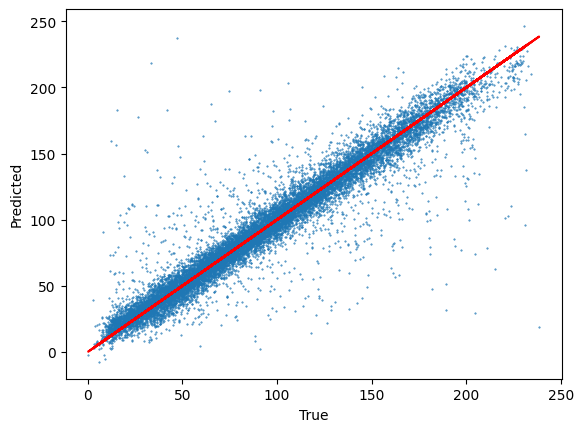

In [78]:
matplotlib.pyplot.scatter(flatLabels, flatPreds, s=0.2)
matplotlib.pyplot.plot(flatLabels, flatLabels, color='red')
matplotlib.pyplot.xlabel("True")
matplotlib.pyplot.ylabel("Predicted")
matplotlib.pyplot.show()
#R2 score

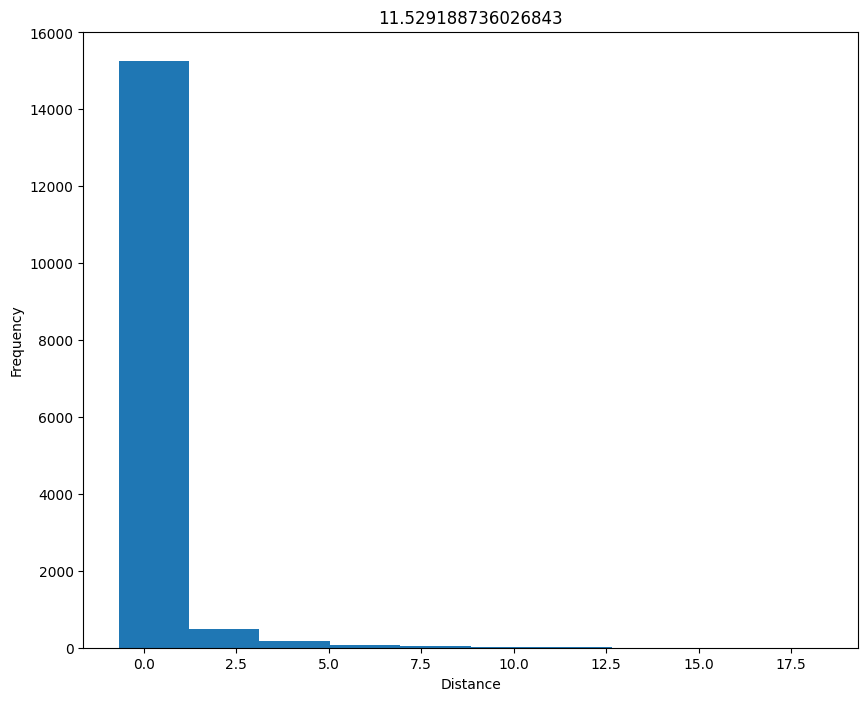

In [76]:
prds = []
for i in flatPreds:
    for k in i:
        for a in k:
            prds.append(a)

lbls = []
for i in flatLabels:
    for k in i:
        lbls.append(k)
sequentialArray = numpy.arange(0, len(prds), 1)
prds = numpy.vstack([prds, sequentialArray]).T
lbls = numpy.vstack([lbls, sequentialArray]).T
from sklearn.metrics.pairwise import paired_distances
dist = paired_distances(lbls, prds)
from scipy import stats
zScore = stats.zscore(dist)
xNorm = (dist - dist.mean()) / dist.std()
matplotlib.pyplot.hist(xNorm)
matplotlib.pyplot.title(dist.std())
matplotlib.pyplot.xlabel("Distance")
matplotlib.pyplot.ylabel("Frequency")
#increase size of plot
matplotlib.pyplot.gcf().set_size_inches(10, 8)
matplotlib.pyplot.show()

In [63]:
npHist = numpy.histogram(dist, bins=200)

In [24]:
flatPreds

[[[146.56312561035156],
  [108.8045654296875],
  [154.33712768554688],
  [48.74774169921875],
  [177.13055419921875],
  [109.4095458984375],
  [106.30758666992188],
  [123.48272705078125],
  [75.61164855957031],
  [92.20489501953125],
  [78.84169006347656],
  [49.5561408996582],
  [95.30769348144531],
  [57.76887512207031],
  [199.56077575683594],
  [41.856990814208984],
  [40.654605865478516],
  [79.47711181640625],
  [141.20721435546875],
  [44.97231674194336],
  [123.51008605957031],
  [124.34880065917969],
  [210.1279296875],
  [83.21414184570312],
  [111.83297729492188],
  [35.65290832519531],
  [140.11032104492188],
  [62.864013671875],
  [56.72446823120117],
  [62.141624450683594],
  [127.51290893554688],
  [63.55311584472656]],
 [[144.57647705078125],
  [51.41276931762695],
  [66.05630493164062],
  [161.46292114257812],
  [113.81895446777344],
  [135.4972381591797],
  [109.51927185058594],
  [102.66293334960938],
  [103.592041015625],
  [48.08552932739258],
  [43.76076889038086

In [16]:
flatLabels

[[154.97074777777777,
  114.355974,
  158.81561,
  48.3279390909091,
  170.46056,
  102.86656,
  114.60124,
  124.48309,
  73.650409,
  94.43022545454546,
  69.30394571428572,
  54.862494000000005,
  85.756795,
  42.77563,
  210.268158,
  45.416549090909086,
  15.80886,
  85.124955,
  147.98677285714285,
  51.79534,
  131.9103690909091,
  115.997435,
  189.14805,
  77.17400727272728,
  108.68744999999998,
  36.64972571428572,
  131.84824,
  55.27034,
  51.33247111111111,
  78.42886,
  132.43525,
  55.4201],
 [142.26455,
  44.22594,
  47.97304,
  152.15003000000002,
  115.613435,
  132.59706749999998,
  101.42897333333332,
  103.01113,
  104.2465175,
  55.97421,
  43.085985,
  76.53202666666668,
  155.74772111111108,
  12.51603,
  12.458155,
  122.568705,
  149.9176922222222,
  139.66189999999995,
  72.39733800000002,
  153.292145,
  92.2027425,
  31.08644,
  136.27204,
  113.19754,
  196.709595,
  122.4688475,
  165.36684899999997,
  113.83272428571428,
  203.9750033333333,
  45.736131

In [14]:
allPredictions[0]

tensor([[146.5631],
        [108.8046],
        [154.3371],
        [ 48.7477],
        [177.1306],
        [109.4095],
        [106.3076],
        [123.4827],
        [ 75.6116],
        [ 92.2049],
        [ 78.8417],
        [ 49.5561],
        [ 95.3077],
        [ 57.7689],
        [199.5608],
        [ 41.8570],
        [ 40.6546],
        [ 79.4771],
        [141.2072],
        [ 44.9723],
        [123.5101],
        [124.3488],
        [210.1279],
        [ 83.2141],
        [111.8330],
        [ 35.6529],
        [140.1103],
        [ 62.8640],
        [ 56.7245],
        [ 62.1416],
        [127.5129],
        [ 63.5531]], device='cuda:0')

In [15]:
trainingDatasets.peptides

[array([[16,  3, 17, 16, 16,  9,  4,  8,  4,  4,  1, 11,  9,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]]),
 array([[12, 10, 10,  8,  5,  4, 12, 10,  8,  3, 10,  9,  0,  0,  0,  